## Final Project for Applied Data Science
### Model on Car Accident Severity Prediction

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 
from sklearn import metrics

In [4]:
collision=pd.read_csv('/Users/livi/Documents/Data Science Skills/Final Capstone project/Data-Collisions.csv')
#print(collision.columns)
#collision.head()

### What we want to know?
 How do we avoid accident? what time, what method,what location?
 if one accident is prefer to happen, what is my percentage of survival?

### Preprocessing
1. Make the data to be balanced
2. Select data to address the following questions:
    1. Is there any location correlated with large severity?
    2. what type of collision is the more dangerous?
    3. Is it more safe to ride a bike, drive a car, or walk?
    4. which time and which day would have more accidents? weekdays or weekends?
    5. which type of junction?
3. what is the data type of my dataset?
3. Is there any empty data? is there any null data? remove or guess?
4. Is the data balance now?

In [5]:
selected_columns=['SEVERITYCODE','LOCATION','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','INCDATE','INCDTTM','SDOT_COLCODE','INATTENTIONIND','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','PEDROWNOTGRNT','SPEEDING','ST_COLCODE','SEGLANEKEY','CROSSWALKKEY','HITPARKEDCAR']
C=collision[selected_columns]
#C.head()

In [6]:
#print(C.shape)
#C.isnull().sum()

In [7]:
#temp=C.drop(['LOCATION','INCDATE','INCDTTM'],axis=1)
#for col in temp:
#    print(col,C[col].unique())
#print(len(C['LOCATION'].unique()))
#C.info()

According to the number of null value and unique values in each column, we could see that we need to change clean data in the following columns:<br>
- LOCATION to number
- COLLISIONTYPE to number
- ST_COLCODE (remove nan and '', to number)
- INCDATE to date
- INCDTTM to date 
- UNDERINFL (Unknown to nan, [N,Y] to [0,1])
- HITPARKEDCAR ([N,Y] to [0,1])
- WEATHER (Unknown to nan, remove nan, to number)
- ROADCOND (Unknown to nan, remove nan, to number)
- LIGHTCOND (Unknown to nan, remove nan, to number)
- PEDROWNOTGRNT (drop, cross check with metadata)
- SPEEDING (drop, cross check with metadata)
- INATTENTIONIND (drop, cross check with metadata)


1. After change data to proper data type and unknown to nan, lets see if the data is large enought for us to do model setting, or should we assign random value into the nan position. 
2. lets see the possibility to group some data, for example, whether it is possible to group time into weekday/weekend, season or month?, light condition to dark/light or more in detail, location on nearby avenue?

In [8]:
C_C=C.drop(['PEDROWNOTGRNT','SPEEDING','INATTENTIONIND'],axis=1)
for col in ['LIGHTCOND','ROADCOND', 'WEATHER']:
    C_C[col].replace(to_replace=['Unknown'],value=[float('NaN')],inplace=True)
for col in ['ST_COLCODE','HITPARKEDCAR','UNDERINFL']:
    C_C[col].replace(to_replace=['N','Y','0','1'],value=[int(0),int(1),int(0),int(1)],inplace=True)
C_C.dropna(inplace=True)
C_C['INCDATE']=pd.to_datetime(C_C['INCDATE'])
C_C['MONTH']=C_C['INCDATE'].dt.month
C_C['DOW']=C_C['INCDATE'].dt.dayofweek
C_C['INCDTTM']=pd.to_datetime(C_C['INCDTTM'])
C_C['HOUR']=C_C['INCDTTM'].dt.hour
C_C.drop(['INCDATE','INCDTTM'],axis=1,inplace=True)
C_C[['ST_COLCODE']]=C_C[['ST_COLCODE']].astype(int)
#C_C.head()

In [9]:
'''print(C_C.shape)
print(C_C.info())
print(C_C.groupby('SEVERITYCODE').count()[['LOCATION']])
temp=C_C.drop(['LOCATION','INCDATE','INCDTTM'],axis=1)
for col in temp:
    print(col,C_C[col].unique())
'''

"print(C_C.shape)\nprint(C_C.info())\nprint(C_C.groupby('SEVERITYCODE').count()[['LOCATION']])\ntemp=C_C.drop(['LOCATION','INCDATE','INCDTTM'],axis=1)\nfor col in temp:\n    print(col,C_C[col].unique())\n"

From the data above, we could see that we have aproximate 55000 data points for further processing by simply removing nan data. The next step we will balance the data and take a look at which factor has strong correlation with the results.

In [10]:
Count_Sev=C_C.groupby('SEVERITYCODE').count()[['LOCATION']]
Count_Sev_rm_leng=int(Count_Sev.iloc[0]-Count_Sev.iloc[1])
Count_Sev_rm_leng

import random
SEV1=C_C[C_C['SEVERITYCODE']==1]
C_C.drop(index=random.sample(SEV1.index.tolist(), Count_Sev_rm_leng),inplace=True)
C_C.reset_index(drop=True)
Count_Sev=C_C.groupby('SEVERITYCODE').count()[['LOCATION']]

In [11]:
'''print(Count_Sev)
print(C_C.shape)
print(C_C.info())
print(C_C.groupby('SEVERITYCODE').count()[['LOCATION']])
temp=C_C.drop(['LOCATION','INCDATE','INCDTTM'],axis=1)
for col in temp:
    print(col,C_C[col].unique())
'''
C_C.head()
print(C_C.columns[2:])

Index(['COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT',
       'SDOT_COLCODE', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'ST_COLCODE', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR', 'MONTH',
       'DOW', 'HOUR'],
      dtype='object')


In the following parts, we will plot to see the correlation of severitycode with different parameters, plot and check correlation. 

SEVERITYCODE      1      2
COLLISIONTYPE             
Angles         9888  13395
Cycles          296   4610
Head On         525    859
Left Turn      3926   5346
Other          8025   5933


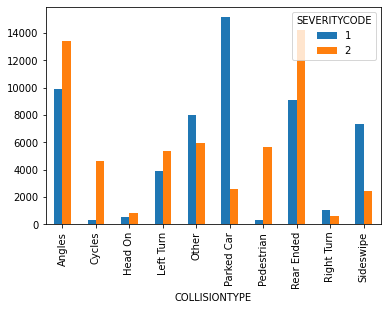

SEVERITYCODE        1        2
PERSONCOUNT                   
0              1720.0   1736.0
1              3926.0   2942.0
2             32999.0  26285.0
3             10136.0  13059.0
4              3897.0   6111.0


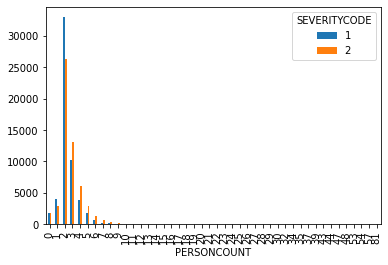

SEVERITYCODE        1        2
PEDCOUNT                      
0             55306.0  49652.0
1               302.0   5735.0
2                10.0    204.0
3                 NaN     21.0
4                 NaN      4.0


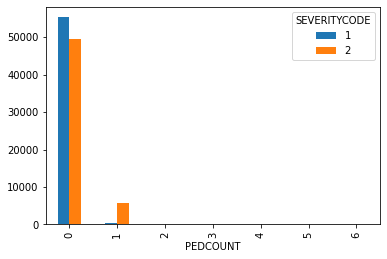

SEVERITYCODE        1        2
PEDCYLCOUNT                   
0             55321.0  50960.0
1               297.0   4616.0
2                 NaN     42.0


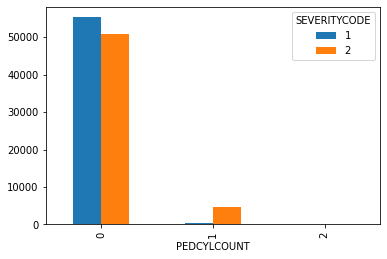

SEVERITYCODE      1       2
ST_COLCODE                 
0             148.0  2436.0
1              63.0  1002.0
2              75.0  1948.0
3               8.0   196.0
4               8.0    88.0


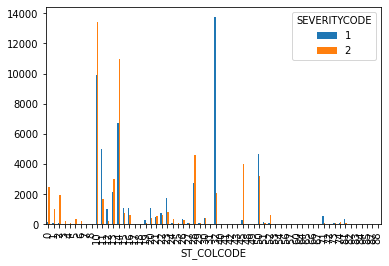

SEVERITYCODE        1        2
SDOT_COLCODE                  
0              1068.0    361.0
11            26935.0  23611.0
12              404.0     27.0
13             1800.0    193.0
14            15710.0  16943.0


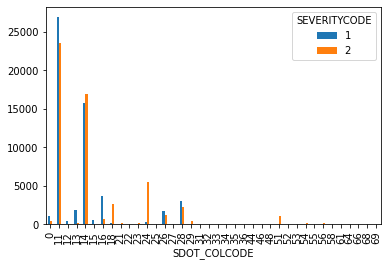

SEVERITYCODE      1      2
UNDERINFL                 
0.0           52962  52120
1.0            2656   3498


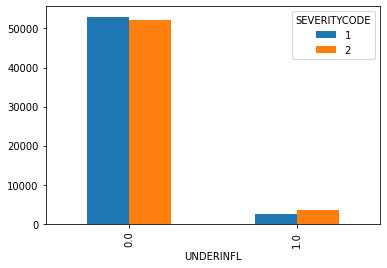

SEVERITYCODE             1        2
WEATHER                            
Blowing Sand/Dirt     13.0     13.0
Clear              35585.0  35479.0
Fog/Smog/Smoke       162.0    182.0
Other                 90.0     78.0
Overcast            8958.0   8601.0


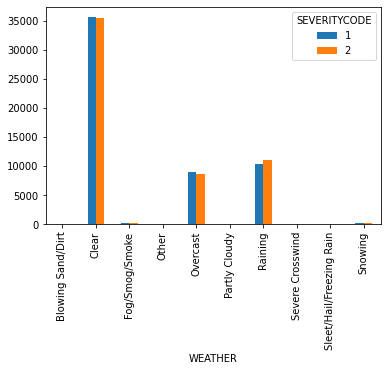

SEVERITYCODE       1      2
ROADCOND                   
Dry            39847  39561
Ice              397    263
Oil               14     24
Other             30     42
Sand/Mud/Dirt     16     21


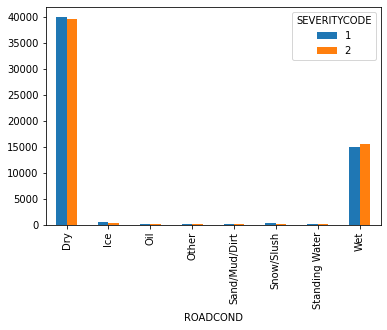

SEVERITYCODE                  1      2
LIGHTCOND                             
Dark - No Street Lights     502    318
Dark - Street Lights Off    385    309
Dark - Street Lights On   15858  14247
Dark - Unknown Lighting       4      4
Dawn                        769    808


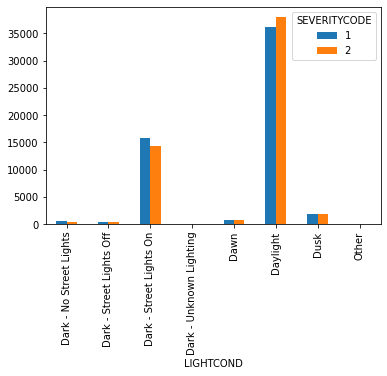

SEVERITYCODE      1      2
HITPARKEDCAR              
0             53486  55212
1              2132    406


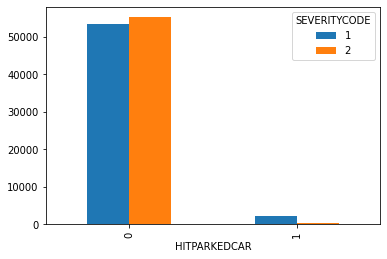

SEVERITYCODE     1     2
MONTH                   
1             4668  4454
2             4087  3766
3             4629  4527
4             4618  4561
5             4728  4939


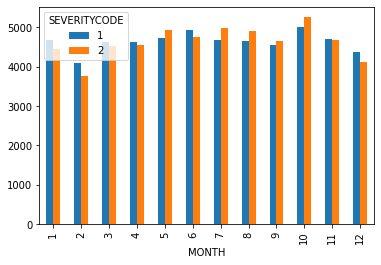

SEVERITYCODE     1     2
DOW                     
0             7359  7614
1             8102  8319
2             8104  8349
3             8333  8666
4             9307  9143


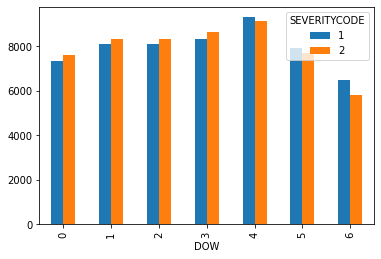

SEVERITYCODE     1     2
HOUR                    
0             8856  7941
1             1125   806
2             1150   843
3              550   331
4              399   267


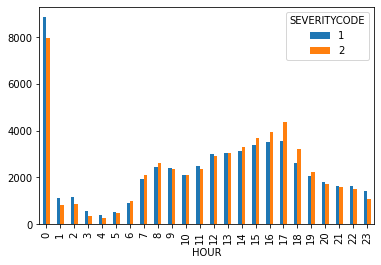

In [12]:
for i in ['COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT','ST_COLCODE',
       'SDOT_COLCODE', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND','HITPARKEDCAR', 'MONTH','DOW','HOUR']:
    df=pd.concat([C_C[['SEVERITYCODE','SEGLANEKEY']],C_C[i]],axis=1)
#TEST=df.groupby([df.columns[2],df.columns[0]]).count().reset_index()
    TEST=pd.pivot_table(df,index=df.columns[2],columns=['SEVERITYCODE'],values='SEGLANEKEY',aggfunc='count')
    print(TEST.head())
#print(TEST.pivot(index='SEVERITYCODE',columns=df.columns[1],values='HOUR'))
    TEST.plot(kind='bar')
    plt.show()

The machine learning model will build on the factors that will cause the disaster. Here, we consider the collision type, the code corresponding to the location, type of collision, drug, weather, road condition, segment of a lane, segment of a crosswalk the month, day of a week and hour of a day. Because of the binary output, we could use binary approximation.

In [13]:
ML_D=C_C.drop(['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT','HITPARKEDCAR','SDOT_COLCODE'],axis=1)
ML_D=ML_D.reset_index(drop=True)
ML_D.head()

,SEVERITYCODE,LOCATION,COLLISIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,ST_COLCODE,SEGLANEKEY,CROSSWALKKEY,MONTH,DOW,HOUR
0,2,5TH AVE NE AND NE 103RD ST,Angles,0.0,Overcast,Wet,Daylight,10,0,0,3,2,14
1,1,2ND AVE BETWEEN MARION ST AND MADISON ST,Other,0.0,Clear,Dry,Daylight,23,0,0,3,4,9
2,2,SWIFT AVE S AND SWIFT AV OFF RP,Angles,0.0,Raining,Wet,Daylight,10,0,0,1,2,8
3,1,DENNY WAY AND WESTLAKE AVE,Angles,0.0,Raining,Wet,Daylight,10,0,0,12,1,0
4,2,BROADWAY AND E PIKE ST,Cycles,0.0,Clear,Dry,Daylight,5,6855,0,4,2,17


In [14]:
#Preprocessing of train test_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
for col in ['LOCATION','COLLISIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']:
    tran=preprocessing.LabelEncoder()
    ML_D[col]=tran.fit_transform(ML_D[col])
#Normalize the data
for col in ML_D.columns[1:]:
    ML_D[col]=preprocessing.StandardScaler().fit(ML_D[[col]].values).transform(ML_D[[col]])
print(ML_D.head())
xtrain,xtest,ytrain,ytest=train_test_split(ML_D.iloc[:,1:],ML_D.iloc[:,0],test_size=0.2,random_state=4)
print(xtrain.shape,xtest.shape)
print(ytrain.shape,ytest.shape)

SEVERITYCODE  LOCATION  COLLISIONTYPE  UNDERINFL   WEATHER  ROADCOND  \
0             2 -0.501417      -1.482728     -0.242  0.724234  1.615733   
1             1 -1.081872      -0.108672     -0.242 -0.710987 -0.625113   
2             2  1.611063      -1.482728     -0.242  1.681048  1.615733   
3             1  0.039398      -1.482728     -0.242  1.681048  1.615733   
4             2 -0.091228      -1.139214     -0.242 -0.710987 -0.625113   

   LIGHTCOND  ST_COLCODE  SEGLANEKEY  CROSSWALKKEY     MONTH       DOW  \
0   0.595874   -0.767140   -0.100845     -0.169671 -1.049883 -0.486533   
1   0.595874    0.106164   -0.100845     -0.169671 -1.049883  0.557498   
2   0.595874   -0.767140   -0.100845     -0.169671 -1.639068 -0.486533   
3   0.595874   -0.767140   -0.100845     -0.169671  1.601450 -1.008548   
4   0.595874   -1.103026    1.511762     -0.169671 -0.755290 -0.486533   

       HOUR  
0  0.359497  
1 -0.369412  
2 -0.515194  
3 -1.681449  
4  0.796842  
(88988, 12) (22248, 12)

In [15]:
#KNN, decision tree, logic regression and SVM
def JAF(test,hat):
    F1=metrics.f1_score(test,hat)
    ACC=metrics.accuracy_score(test,hat)
    JACC=metrics.jaccard_score(test,hat)
    loss=metrics.log_loss(test,hat)
    return [JACC,ACC,F1,loss]

In [16]:
from sklearn.neighbors import KNeighborsClassifier
all_score=[]
for k in range(1,30,2):
    KNN_yhat=KNeighborsClassifier(n_neighbors=k).fit(xtrain,ytrain).predict(xtest)
    all_score.append(JAF(ytest,KNN_yhat))
KNNscore=pd.DataFrame(all_score)
KNNscore.head()

,0,1,2,3
0,0.436048,0.608190,0.607289,17.380014
1,0.452501,0.623607,0.623064,17.380014
2,0.458674,0.631428,0.628892,17.380014
3,0.462230,0.636821,0.632226,17.380014
4,0.463367,0.639833,0.633289,17.380014


JACC       ACC        F1    LogLoss
k                                         
1  0.436048  0.608190  0.607289  17.380014
3  0.452501  0.623607  0.623064  17.380014
5  0.458674  0.631428  0.628892  17.380014
7  0.462230  0.636821  0.632226  17.380014
9  0.463367  0.639833  0.633289  17.380014
The max JACC is at 0.4693569418708393 with k=27
The max ACC is at 0.6524631427544049 with k=27
The max F1 is at 0.6388603456328819 with k=27


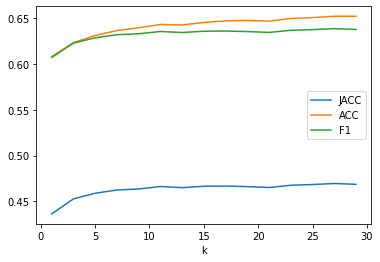

The min Logloss is at 17.380014079209644 with k=1


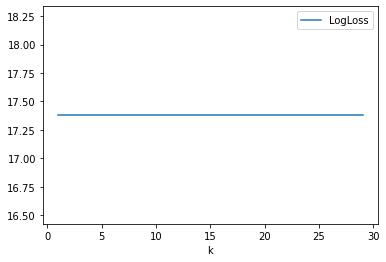

In [17]:
score=KNNscore
score['k']=list(range(1,30,2))
score.set_index('k',inplace=True)
score.columns=['JACC','ACC','F1','LogLoss']
print(score.head())
score[['JACC','ACC','F1']].plot(kind='line')
for i in ['JACC','ACC','F1']:
    print('The max '+i+' is at '+str(score[i].max())+' with k='+str(2*score[i].argmax()+1))
plt.show()
score[['LogLoss']].plot(kind='line')
print('The min Logloss is at '+str(score['LogLoss'].min())+' with k='+str(2*score['LogLoss'].argmin()+1))
plt.show()


In [18]:
from sklearn.tree import DecisionTreeClassifier
all_score=[]
for d in range(1,10):
    DT_yhat=DecisionTreeClassifier(criterion='entropy',max_depth=d).fit(xtrain,ytrain).predict(xtest)
    all_score.append(JAF(ytest,DT_yhat))

DT_score=pd.DataFrame(all_score)

JACC       ACC        F1    LogLoss
d                                         
1  0.530278  0.557219  0.693048  17.380014
2  0.507391  0.640507  0.673204  17.380014
3  0.394859  0.643384  0.566164  17.380014
4  0.472572  0.680196  0.641832  17.380014
5  0.483687  0.686309  0.652007  17.380014
The max JACC is at 0.5302784665267977 with k=1
The max ACC is at 0.687792161093132 with k=8
The max F1 is at 0.6930483282958901 with k=1


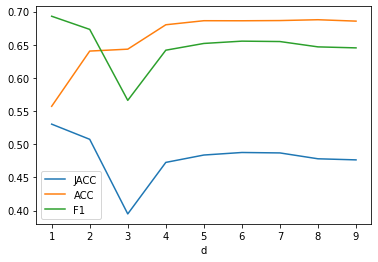

The min Logloss is at 17.380014079209644 with k=1


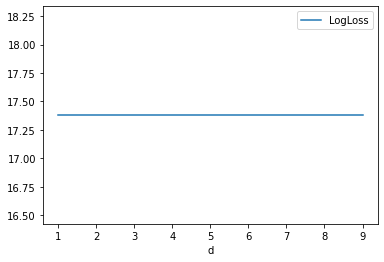

In [19]:
score=DT_score
score['d']=list(range(1,10))
score.set_index('d',inplace=True)
score.columns=['JACC','ACC','F1','LogLoss']
print(score.head())
score[['JACC','ACC','F1']].plot(kind='line')
for i in ['JACC','ACC','F1']:
    print('The max '+i+' is at '+str(score[i].max())+' with k='+str(score[i].argmax()+1))
plt.show()
score[['LogLoss']].plot(kind='line')
print('The min Logloss is at '+str(score['LogLoss'].min())+' with k='+str(score['LogLoss'].argmin()+1))
plt.show()


In [20]:
from sklearn import svm
ker=['linear','rbf','sigmoid']
all_score=[]
for i in ker:
    svc_yhat=svm.SVC(kernel=i).fit(xtrain,ytrain).predict(xtest)
    all_score.append(JAF(ytest,svc_yhat))
svc_score=pd.DataFrame(all_score)

JACC       ACC        F1    LogLoss
method                                          
linear   0.505445  0.612145  0.671489  17.380014
rbf      0.421488  0.653901  0.593023  17.380014
sigmoid  0.370343  0.538880  0.540511  17.380014
The max JACC is at 0.5054447501146263 with k=1
The max ACC is at 0.6539014742898238 with k=2
The max F1 is at 0.6714889404956791 with k=1


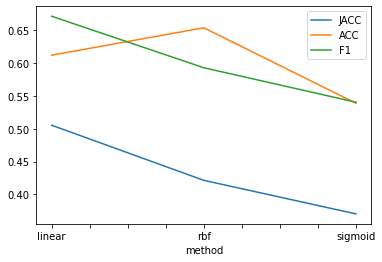

The min Logloss is at 17.380014079209644 with k=1


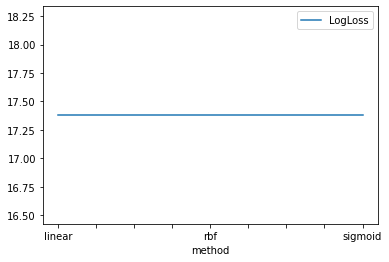

In [23]:
score=svc_score
score['method']=ker
score.set_index('method',inplace=True)
score.columns=['JACC','ACC','F1','LogLoss']
print(score.head())
score[['JACC','ACC','F1']].plot(kind='line')
for i in ['JACC','ACC','F1']:
    print('The max '+i+' is at '+str(score[i].max())+' with k='+str(score[i].argmax()+1))
plt.show()
score[['LogLoss']].plot(kind='line')
print('The min Logloss is at '+str(score['LogLoss'].min())+' with k='+str(score['LogLoss'].argmin()+1))
plt.show()

In [29]:
from sklearn.linear_model import LogisticRegression
solv=['newton-cg','lbfgs','liblinear','sag','saga']
all_score=[]
for i in solv:
    Log_yhat=LogisticRegression(C=0.01,solver=i).fit(xtrain,ytrain).predict(xtest)
    all_score.append(JAF(ytest,Log_yhat))
Log_score=pd.DataFrame(all_score)

JACC       ACC        F1    LogLoss
method                                            
newton-cg  0.497525  0.612235  0.664463  17.380014
lbfgs      0.497583  0.612280  0.664515  17.380014
liblinear  0.497612  0.612280  0.664541  17.380014
sag        0.497525  0.612235  0.664463  17.380014
saga       0.497525  0.612235  0.664463  17.380014
The max JACC is at 0.4976121141525917 with k=3
The max ACC is at 0.612279755483639 with k=2
The max F1 is at 0.6645407171190791 with k=3


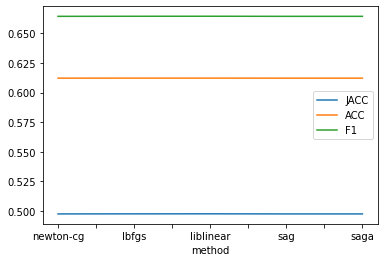

The min Logloss is at 17.380014079209644 with k=1


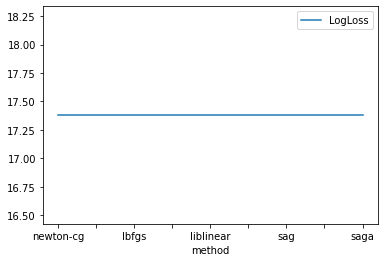

In [30]:
score=Log_score
score['method']=solv
score.set_index('method',inplace=True)
score.columns=['JACC','ACC','F1','LogLoss']
print(score.head())
score[['JACC','ACC','F1']].plot(kind='line')
for i in ['JACC','ACC','F1']:
    print('The max '+i+' is at '+str(score[i].max())+' with k='+str(score[i].argmax()+1))
plt.show()
score[['LogLoss']].plot(kind='line')
print('The min Logloss is at '+str(score['LogLoss'].min())+' with k='+str(score['LogLoss'].argmin()+1))
plt.show()